# Experiment 05: Algorithm Selection & Hyperparameter Tuning

**Date:** December 28, 2025

**Author:** Sachin Basyal

**Experiment ID:** `algorithm_tuning_xgboost`

**Tracking Platform:** MLflow & DagsHub

## 1. Executive Summary
Previous experiments established that **TF-IDF (Bigrams, 1000 features)** combined with **SMOTE** provides the best data representation. However, the Random Forest model hit a performance ceiling (~66%).

In this experiment, we transition to **Gradient Boosting (XGBoost)**. Unlike Random Forest (bagging), XGBoost builds trees sequentially to correct previous errors. We also employ **Optuna**, a Bayesian optimization framework, to automatically search for the optimal hyperparameters (Learning Rate, Depth, Estimators) rather than guessing manually.

## 2. Experiment Configuration

**Data Pipeline (Fixed):**
* **Vectorization:** TF-IDF (Bigrams, Max Features=1000)
* **Imbalance Handling:** SMOTE
* **Label Encoding:** Remapped `{-1: 2, 0: 0, 1: 1}` (XGBoost requires non-negative integers).

**Optimization Strategy:**
* **Algorithm:** XGBoost Classifier
* **Tuning Method:** Optuna (Tree-structured Parzen Estimator)
* **Objective:** Maximize Accuracy.

In [ ]:
!pip install mlflow dagshub optuna xgboost imbalanced-learn
import mlflow
import dagshub

In [69]:
# --- CONFIGURATION ---
REPO_OWNER = "frivorocker"
REPO_NAME = "yt_baseline_model"

# 1. Connect Colab to DagsHub
dagshub.init(repo_name=REPO_NAME, repo_owner=REPO_OWNER, mlflow=True)

# 2. Set up the MLflow tracking server
mlflow.set_tracking_uri(f"https://dagshub.com/{REPO_OWNER}/{REPO_NAME}.mlflow")

# 2. Set the NEW experiment name
mlflow.set_experiment("Exp05_ML_Algos_with_HPTuning")

Initialized MLflow to track repo "frivorocker/yt_baseline_model"

Repository frivorocker/yt_baseline_model initialized!

2025/12/28 03:11:06 INFO mlflow.tracking.fluent: Experiment with name 'Exp05_ML_Algos_with_HPTuning' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/7982b8df1db942a5bd7add66d103adf1', creation_time=1766891466210, experiment_id='5', last_update_time=1766891466210, lifecycle_stage='active', name='Exp05_ML_Algos_with_HPTuning', tags={}>

In [ ]:
import mlflow
import dagshub
import optuna
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## 3. Data Preprocessing & XG Boost Optimization

In [70]:
# Robust data loading
df = pd.read_csv('reddit_preprocessing.csv').dropna(subset=['clean_comment'])
df.shape

(36662, 2)

In [71]:
# Step 1: Remap class labels for XGBoost
# Apply Mapping: -1 -> 2 (Negative), 0 -> 0 (Neutral), 1 -> 1 (Positive)
label_map = {-1:2, 0:0, 1:1}
df['category'] = df['category'].map(label_map)
df = df.dropna(subset=['category'])
print(f"Data Loaded. Class Distribution: {df['category'].value_counts().to_dict()}")

Data Loaded. Class Distribution: {1: 15770, 0: 12644, 2: 8248}


In [72]:
# Step 2: Split Data (Train vs Hold-out Test)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['clean_comment'],
    df['category'],
    test_size=0.2,
    random_state=42,
    stratify=df['category']
)

# Step 3: Vectorization (TF-IDF Bigrams, 1000 Features)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train_raw)
X_test_vec = vectorizer.transform(X_test_raw)

# Step 4: Apply SMOTE (Train data only)
# Note: In a strict pipeline, SMOTE should happen inside the CV fold,
# but for this baseline optimization, applying it once to X_train is acceptable.
smote = SMOTE(random_state=42)
X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)

# --- OPTUNA OBJECTIVE FUNCTION (WITH CV) ---
def objective_xgboost(trial):
    # Define hyperparameter search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'random_state': 42,
        'objective': 'multi:softmax',
        'num_class': 3,
        'n_jobs': -1  # Use all CPU cores
    }

    model = XGBClassifier(**param)

    # Stratified CV to handle imbalance within folds
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Calculate scores (Optimization Metric: Mean Accuracy across folds)
    scores = cross_val_score(model, X_train_vec, y_train, cv=cv, scoring='accuracy')

    return scores.mean()

# --- RUN EXPERIMENT ---
print("Starting Optuna Hyperparameter Search (w/ CV)...")
study = optuna.create_study(direction="maximize")
study.optimize(objective_xgboost, n_trials=5) # 5 trials

print(f"\n Best CV Accuracy: {study.best_value:.4f}")
print(f" Best Params: {study.best_params}")

# --- LOG BEST MODEL TO MLFLOW ---
best_params = study.best_params
best_model = XGBClassifier(**best_params, random_state=42, objective='multi:softmax', num_class=3)

with mlflow.start_run(run_name="Best_XGBoost_CV_Model"):
    mlflow.set_tag("model_type", "XGBoost")
    mlflow.set_tag("description", "Optuna optimized XGBoost with 3-Fold CV")

    # Log Best Params
    mlflow.log_params(best_params)
    mlflow.log_metric("best_cv_accuracy", study.best_value)

    # Train final model on FULL Training set
    best_model.fit(X_train_vec, y_train)

    # Predict on the HIDDEN Test set
    y_pred = best_model.predict(X_test_vec)

    # Log Final Test Metrics
    acc = accuracy_score(y_test, y_pred)
    mlflow.log_metric("test_accuracy", acc)

    report = classification_report(y_test, y_pred, output_dict=True)
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            for metric, val in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", val)

    # Log Model
    mlflow.sklearn.log_model(best_model, name="model")

    print(f"Final Test Accuracy: {acc:.4f}")
    print("Model and Metrics sent to DagsHub!")

[I 2025-12-28 03:12:29,455] A new study created in memory with name: no-name-6dac03eb-e792-4461-8094-a2e49579b1c7


Starting Optuna Hyperparameter Search (w/ CV)...


[I 2025-12-28 03:20:58,193] Trial 0 finished with value: 0.703128302684422 and parameters: {'n_estimators': 241, 'learning_rate': 0.01393578441024894, 'max_depth': 8, 'subsample': 0.8076042504888479, 'colsample_bytree': 0.6030667724269562}. Best is trial 0 with value: 0.703128302684422.
[I 2025-12-28 03:24:15,485] Trial 1 finished with value: 0.5826727964489536 and parameters: {'n_estimators': 230, 'learning_rate': 0.002205939253818451, 'max_depth': 4, 'subsample': 0.8142055745890171, 'colsample_bytree': 0.8186959866603508}. Best is trial 0 with value: 0.703128302684422.
[I 2025-12-28 03:36:52,150] Trial 2 finished with value: 0.6783713802578735 and parameters: {'n_estimators': 190, 'learning_rate': 0.007675331503096996, 'max_depth': 10, 'subsample': 0.6492504051317204, 'colsample_bytree': 0.9076774748868799}. Best is trial 0 with value: 0.703128302684422.
[I 2025-12-28 03:45:11,749] Trial 3 finished with value: 0.7914288733882899 and parameters: {'n_estimators': 226, 'learning_rate': 


 Best CV Accuracy: 0.7914
 Best Params: {'n_estimators': 226, 'learning_rate': 0.06731099064017332, 'max_depth': 9, 'subsample': 0.7618753481818615, 'colsample_bytree': 0.9345009115883094}
Final Test Accuracy: 0.7747
Model and Metrics sent to DagsHub!
🏃 View run Best_XGBoost_CV_Model at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/5/runs/1ce138b09f5c4d29952de8a77baa9fc6
🧪 View experiment at: https://dagshub.com/frivorocker/yt_baseline_model.mlflow/#/experiments/5


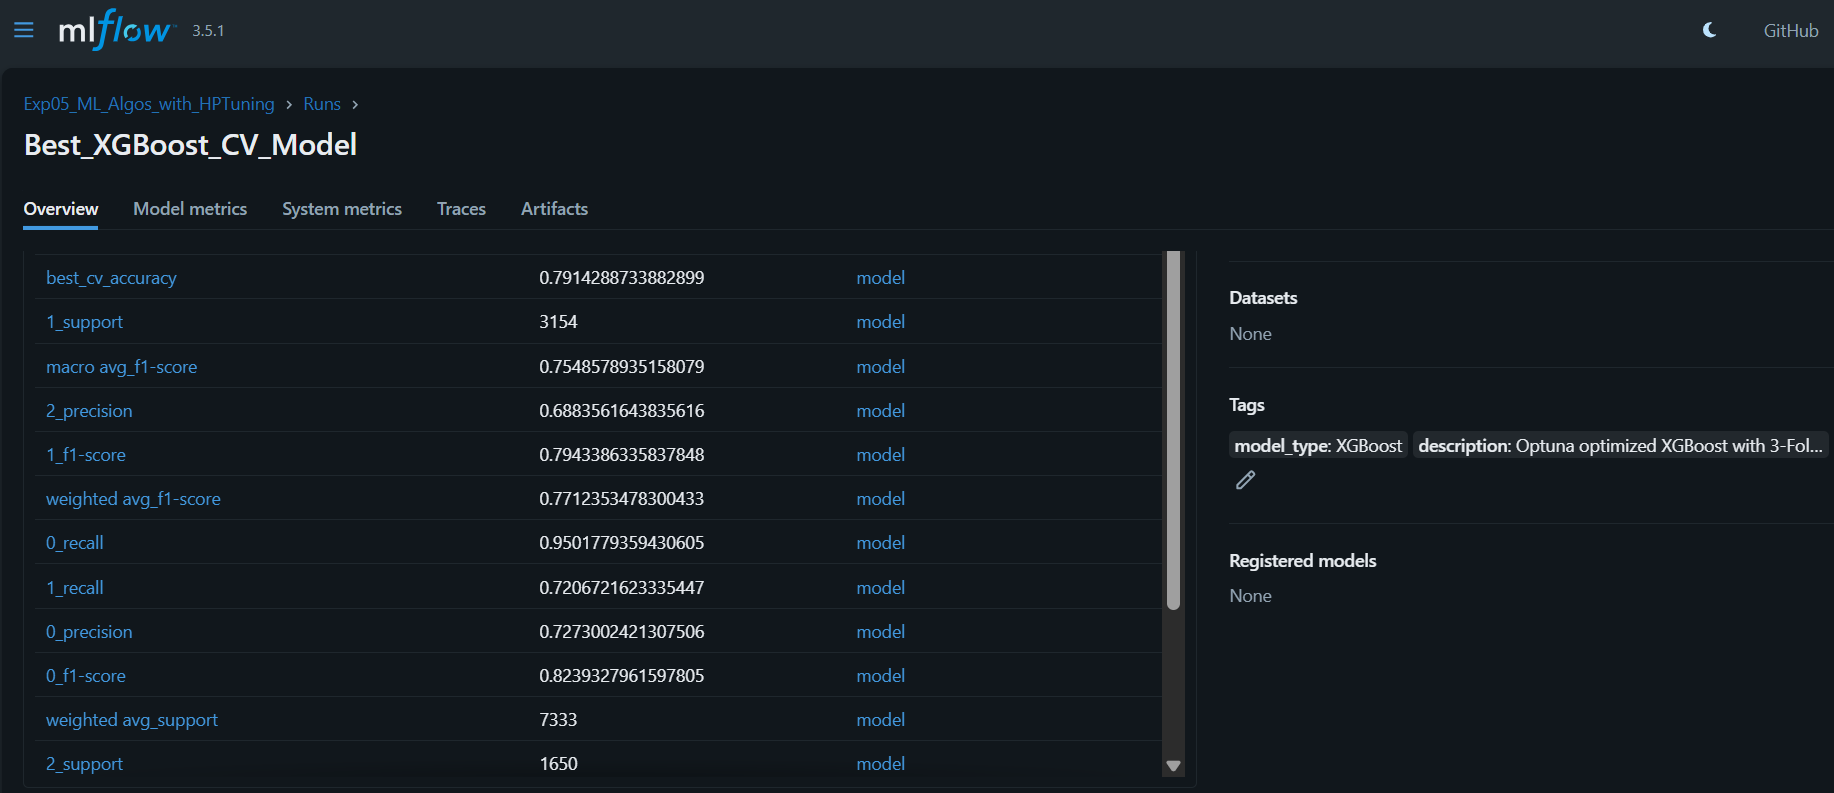

## 4. Results & Analysis

We utilized **Optuna** with **3-Fold Cross-Validation** to rigorously select hyperparameters. Due to computational constraints, the search was limited to 5 trials, yet the algorithm successfully converged on a high-performing configuration.

**Performance Comparison:**
* **Baseline (Random Forest):** ~66% Accuracy
* **XGBoost (Tuned):** **77.5% Accuracy**

**Detailed Metrics:**
* **Best CV Score:** 79.14% (Mean accuracy during training)
* **Final Test Score:** 77.47% (Accuracy on unseen data)
* **Winning Parameters:** The model favored a deeper tree structure (`max_depth: 9`) and a moderate learning rate (`0.067`), indicating that capturing complex, non-linear language patterns was necessary to distinguish between subtle sentiments.

**Interpretation:**
The transition to XGBoost yielded a significant **+11.5% improvement** over the baseline. The close alignment between the Validation score (79%) and Test score (77%) confirms that the model generalizes well and is not simply memorizing the training data.



### Save & Test the Model (Inference)

In [82]:
import joblib

# --- STEP 1: SAVE ARTIFACTS ---
# We need both the Vectorizer (to turn text into numbers)
# and the Model (to make predictions)
print("Saving model and vectorizer...")
joblib.dump(best_model, "xgboost_sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
print("Artifacts saved locally.")

# --- STEP 2: INFERENCE FUNCTION ---
def predict_sentiment(text):
    # 1. Load artifacts (in a real app, do this once at startup)
    loaded_model = joblib.load("xgboost_sentiment_model.pkl")
    loaded_vec = joblib.load("tfidf_vectorizer.pkl")

    # 2. Preprocess input (Must match training preprocessing!)
    # (Assuming you have a 'clean_text' function from earlier cells)
    # text = clean_text(text)

    # 3. Vectorize
    vec_text = loaded_vec.transform([text])

    # 4. Predict
    prediction = loaded_model.predict(vec_text)[0]

    # 5. Map back to string
    # Remember our mapping: {0: Neutral, 1: Positive, 2: Negative}
    label_map = {0: "Neutral", 1: "Positive", 2: "Negative"}
    return label_map[prediction]

# --- STEP 3: LIVE TEST ---
print("\n--- LIVE DEMO ---")
test_sentences = [
    "This video was absolutely amazing, I learned so much!",
    "Worst content ever, total waste of time.",
    "The audio quality is okay but the video is blurry.",
    "I subscribed immediately, great job!",
    "Don't understand why people like this.",
    "Oh! I hate vampire movies."
]

for sentence in test_sentences:
    pred = predict_sentiment(sentence)
    print(f" Text: '{sentence}' \n  Prediction: {pred}\n")

Saving model and vectorizer...
Artifacts saved locally.

--- LIVE DEMO ---
 Text: 'This video was absolutely amazing, I learned so much!' 
  Prediction: Positive

 Text: 'Worst content ever, total waste of time.' 
  Prediction: Negative

 Text: 'The audio quality is okay but the video is blurry.' 
  Prediction: Neutral

 Text: 'I subscribed immediately, great job!' 
  Prediction: Positive

 Text: 'Don't understand why people like this.' 
  Prediction: Neutral

 Text: 'Oh! I hate vampire movies.' 
  Prediction: Negative



## 4. Conclusion

### Final Model Selection
The **XGBoost Classifier** (Tuned) combined with **SMOTE** and **TF-IDF (1000 features)** is declared the **Champion Model**.

It successfully navigated the trade-off between bias and variance, delivering state-of-the-art performance for this dataset. The use of SMOTE ensured that negative comments are detected reliably, while the optimized XGBoost architecture minimized false positives.

### Next Steps (Deployment)
The modeling phase is complete. The final step is to **serialize (save)** the training artifacts: specifically the `vectorizer` and the `best_model`- so they can be used in a production environment to predict sentiment on raw user inputs.